In [223]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import xgboost as xgb

%matplotlib inline

## Load Data and Preprocessing

In [210]:
# Read the data
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [211]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [212]:
# Apply LabelEncoder to categorical features
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder() 
        lbl.fit(list(train[c].values) + list(test[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

# shape        
print('Shape train: {}\nShape test: {}'.format(train.shape, test.shape))

Shape train: (4209, 378)
Shape test: (4209, 377)


In [88]:
train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,37,23,20,0,3,27,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,37,21,22,4,3,31,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,24,24,38,2,3,30,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,24,21,38,5,3,30,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,24,23,38,5,3,14,3,13,...,0,0,0,0,0,0,0,0,0,0


In [76]:
test.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,24,23,38,5,3,26,0,22,0,...,0,0,0,1,0,0,0,0,0,0
1,2,46,3,9,0,3,9,6,24,0,...,0,0,1,0,0,0,0,0,0,0
2,3,24,23,19,5,3,0,9,9,0,...,0,0,0,1,0,0,0,0,0,0
3,4,24,13,38,5,3,32,11,13,0,...,0,0,0,1,0,0,0,0,0,0
4,5,49,20,19,2,3,31,8,12,0,...,1,0,0,0,0,0,0,0,0,0


In [213]:
## Combine the datasets (train and test)
full_data = pd.concat([train.drop(["y"], axis=1), test])
print ("The training and testing data sets combined contains {} rows and {} columns"
       .format(full_data.shape[0], full_data.shape[1])
      )

The training and testing data sets combined contains 8418 rows and 377 columns


## Dimensionality Reduction

Let's look at the items in the training set that have the same value throughout all of our dataset.

In [214]:
## Select all columns in our train dataset that only have 1 unique value
train.loc[:,(train.apply(pd.Series.nunique) == 1)].columns.tolist()

['X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

What about in the test set? Are there any similar columns?

In [199]:
## Select all columns in our test dataset that only have 1 unique value
test.loc[:,(test.apply(pd.Series.nunique) == 1)].columns.tolist()

['X257', 'X258', 'X295', 'X296', 'X369']

In [215]:
from sklearn.decomposition import PCA
n_comp = 10

# PCA
pca = PCA(n_components=n_comp)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

y_train = train["y"]
y_mean = np.mean(y_train)

In [230]:
from sklearn.decomposition import FactorAnalysis

n_comp = 10

# PCA
FA = FactorAnalysis(n_components=n_comp)
FA_results_train = FA.fit_transform(train.drop(["y"], axis=1))
FA_results_test = FA.transform(test)

FA.components_


array([[  2.43731890e+03,  -1.71349769e-01,   7.30136728e-01, ...,
         -3.80236902e-04,  -3.34636236e-04,   1.09636384e-03],
       [ -2.40878715e-05,  -1.35733231e+00,   1.13868333e+00, ...,
         -1.93407202e-04,  -2.58620491e-05,  -1.90290136e-04],
       [  7.31272808e-05,   2.35314714e+00,  -1.87267515e+00, ...,
          6.29720691e-04,  -1.07582497e-06,   4.22842817e-04],
       ..., 
       [ -0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,  -0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,  -0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,  -0.00000000e+00, ...,
          0.00000000e+00,  -0.00000000e+00,  -0.00000000e+00]])

0.9999973867442431

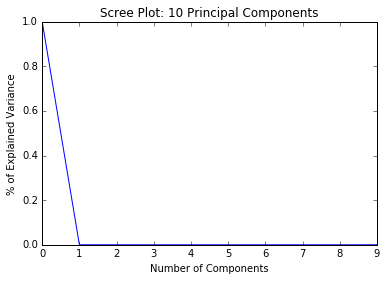

In [216]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

In [217]:
# prepare dict of params for xgboost to run with
xgb_params = {
    'n_trees': 500, 
    'eta': 0.005,
    'max_depth': 4,
    'subsample': 0.95,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1
}

# form DMatrices for Xgboost training
dtrain = xgb.DMatrix(train.drop('y', axis=1), y_train)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params, 
                   dtrain, 
                   num_boost_round=500, # increase to have better results (~700)
                   early_stopping_rounds=50,
                   verbose_eval=50, 
                   show_stdv=False
                  )

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.6402	test-rmse:12.6382
[50]	train-rmse:11.1048	test-rmse:11.1397
[100]	train-rmse:10.0464	test-rmse:10.1268
[150]	train-rmse:9.33355	test-rmse:9.46396
[200]	train-rmse:8.86051	test-rmse:9.04116
[250]	train-rmse:8.54974	test-rmse:8.77847
[300]	train-rmse:8.34441	test-rmse:8.61416
[350]	train-rmse:8.20576	test-rmse:8.51393
[400]	train-rmse:8.10923	test-rmse:8.45378
[450]	train-rmse:8.03653	test-rmse:8.41779
500


In [218]:
# check f2-score (to get higher score - increase num_boost_round in previous cell)
from sklearn.metrics import r2_score

# now fixed, correct calculation
print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.59318873897


In [222]:
# make predictions and save results
y_pred = model.predict(dtest)
output = pd.DataFrame({'id': test['ID'].astype(np.int32), 'y': y_pred})
output.to_csv('xgboost.csv', index=False)